In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize,LinearSegmentedColormap
import pandas as pd 

In [2]:
import seaborn as sns
from collections import Counter
import datetime 
import os
import torch
import torch.nn as nn
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from torch.optim import lr_scheduler
from torchsummary import summary


from PIL import Image

import sys
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, classification_report, ConfusionMatrixDisplay
os.environ['KMP_DUPLICATE_LIB_OK']='True'

finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"

In [3]:
""" # Dataset manipulation
csv_train = 'dataverse_files/HAM10000_metadata_augmented_3_train.csv'
csv_val = 'dataverse_files/HAM10000_metadata_augmented_3_val.csv'
csv_test = 'dataverse_files/ISIC2018_Task3_Test_GroundTruth_augmented.csv'

# Define your label encoder and decoder
encoder_decoder = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'mel': 3, 'nv': 4}
label_encoder = LabelEncoder()
label_encoder.classes_ = list(encoder_decoder.keys())

# Function to encode labels in a DataFrame
def encode_labels(df, column_name):
    df[column_name] = df[column_name].map(encoder_decoder)
    return df

# Encode labels in the training set
train_df = pd.read_csv(csv_train)
train_df = encode_labels(train_df, 'dx')
train_df.to_csv('dataverse_files/encoded_train.csv', index=False)

# Encode labels in the validation set
val_df = pd.read_csv(csv_val)
val_df = encode_labels(val_df, 'dx')
val_df.to_csv('dataverse_files/encoded_val.csv', index=False)

# Encode labels in the test set
test_df = pd.read_csv(csv_test)
test_df = encode_labels(test_df, 'dx')
test_df.to_csv('dataverse_files/encoded_test.csv', index=False) """

" # Dataset manipulation\ncsv_train = 'dataverse_files/HAM10000_metadata_augmented_3_train.csv'\ncsv_val = 'dataverse_files/HAM10000_metadata_augmented_3_val.csv'\ncsv_test = 'dataverse_files/ISIC2018_Task3_Test_GroundTruth_augmented.csv'\n\n# Define your label encoder and decoder\nencoder_decoder = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'mel': 3, 'nv': 4}\nlabel_encoder = LabelEncoder()\nlabel_encoder.classes_ = list(encoder_decoder.keys())\n\n# Function to encode labels in a DataFrame\ndef encode_labels(df, column_name):\n    df[column_name] = df[column_name].map(encoder_decoder)\n    return df\n\n# Encode labels in the training set\ntrain_df = pd.read_csv(csv_train)\ntrain_df = encode_labels(train_df, 'dx')\ntrain_df.to_csv('dataverse_files/encoded_train.csv', index=False)\n\n# Encode labels in the validation set\nval_df = pd.read_csv(csv_val)\nval_df = encode_labels(val_df, 'dx')\nval_df.to_csv('dataverse_files/encoded_val.csv', index=False)\n\n# Encode labels in the test set\ntest_df = 

In [4]:
train_val_folder = 'dataverse_files/HAM10000_images_pca_augmented_3_resnet'
test_folder = 'dataverse_files/ISIC2018_Task3_Test_Images_resnet'
csv_train = 'dataverse_files/encoded_train.csv'
csv_val = 'dataverse_files/encoded_val.csv'
csv_test = 'dataverse_files/encoded_test.csv'

class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f'{self.image_folder}/{self.data.iloc[idx, 1]}'  # Use index 1 for image paths
        image = Image.open(img_name).convert('RGB')
        
        label = int(self.data.iloc[idx, 2])  # Use index 1 for image labels

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create instances of custom datasets
train_dataset = CustomDataset(csv_file=csv_train, image_folder=train_val_folder, transform=transform)
val_dataset = CustomDataset(csv_file=csv_val, image_folder=train_val_folder, transform=transform)
test_dataset = CustomDataset(csv_file=csv_test, image_folder=test_folder, transform=transform)

# You can create DataLoader instances for each dataset
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset sizes
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Check number of classes
print(f'Number of classes: {len(train_dataset.data.dx.unique())}')
print(f'Number of classes: {len(val_dataset.data.dx.unique())}')
print(f'Number of classes: {len(test_dataset.data.dx.unique())}')


# Check number of images per class in train, val and test sets
print(train_dataset.data.dx.value_counts())
print(val_dataset.data.dx.value_counts())
print(test_dataset.data.dx.value_counts())

Train dataset size: 5178
Validation dataset size: 370
Test dataset size: 1432
Number of classes: 5
Number of classes: 5
Number of classes: 5
dx
4    1100
3    1067
2    1011
1    1000
0    1000
Name: count, dtype: int64
dx
2    80
4    80
3    70
0    70
1    70
Name: count, dtype: int64
dx
4    908
2    217
3    171
1     93
0     43
Name: count, dtype: int64


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 3):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [9]:
def _make_layer(block, inplanes,planes, blocks, stride=1):
    downsample = None  
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(            
            nn.Conv2d(inplanes, planes, 1, stride, bias=False),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))
    return nn.Sequential(*layers)

In [10]:
layers=[3, 4, 6, 3]

In [11]:
layer1 =_make_layer(BasicBlock, inplanes=64,planes=64, blocks=layers[0])
layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

In [12]:
layer2 = _make_layer(BasicBlock, 64, 128, layers[1], stride=2)
layer2

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [13]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=5):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

In [14]:
model = ResNet(block = BasicBlock, layers = layers).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
# Model summary resnet
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [15]:
n_epochs=1

for epoch in range(1,n_epochs+1):
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % 20 == 19:    
                
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20))
        
        running_loss = 0.0
     
print('\nFinished Training')

Epoch 1, batch 20, training loss 0.09694474339485168


KeyboardInterrupt: 

In [15]:
# TRAIN MODEL

now = datetime.datetime.now().strftime("%d-%m-%H-%M")
os.mkdir('model-comparison/'+now)

n_epochs = 2
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()

    for i, (inputs, labels) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

        if i % 20 == 19:
            print("Epoch {}, Batch {}, Training Loss: {:.4f}".format(epoch, i + 1, running_loss / 20))
            running_loss = 0.0

    # Calculate training accuracy
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss / len(val_dataloader))
    val_accuracies.append(val_accuracy)

    print("Epoch {}, Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%".format(
        epoch, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))

print('\nFinished Training')

# Save model
torch.save(model.state_dict(), f'model-comparison/{now}/resnet_model.pt')

# Save history
history = pd.DataFrame({
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
})
history.to_csv(f'model-comparison/{now}/history.csv', index=False)

Epoch 1, Batch 20, Training Loss: 1.4580
Epoch 1, Batch 40, Training Loss: 1.0434
Epoch 1, Batch 60, Training Loss: 1.0159
Epoch 1, Batch 80, Training Loss: 0.9564
Epoch 1, Batch 100, Training Loss: 0.9909
Epoch 1, Batch 120, Training Loss: 0.9781
Epoch 1, Batch 140, Training Loss: 0.9653
Epoch 1, Batch 160, Training Loss: 0.9588
Epoch 1, Training Loss: 0.0136, Training Accuracy: 57.09%, Validation Loss: 1.2610, Validation Accuracy: 54.32%
Epoch 2, Batch 20, Training Loss: 0.9029
Epoch 2, Batch 40, Training Loss: 0.8986
Epoch 2, Batch 60, Training Loss: 0.9421
Epoch 2, Batch 80, Training Loss: 0.8641
Epoch 2, Batch 100, Training Loss: 0.8515
Epoch 2, Batch 120, Training Loss: 0.8431
Epoch 2, Batch 140, Training Loss: 0.8303


In [39]:
def EvaluateModel(y_pred, y_true, target_names, str1, now, save = True):
    
    
    print(f'\n PREDICTING LABELS OF {str1} IMAGES')
    y_pred = y_pred
    
    if save==True:
        #save y_pred to csv file
        os.mkdir('model-comparison/'+now+'/'+str1)
        np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
    
    y_true = y_true

    # Understanding classification power of model on each class    
    report = classification_report(y_true, y_pred, target_names=target_names)
    report_d = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=target_names)).transpose()
    report_d['support']['accuracy'] = report_d['support']['macro avg']

    annot = report_d.copy()
    annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
    annot.iloc[7, 1] = ''
    annot.iloc[7, 0] = ''
    annot['support'] = annot['support'].astype(int)

    # how to save report as image
    norm = Normalize(-1,1)
    cmap = LinearSegmentedColormap.from_list("", [[norm(-1.0), "white"],[norm( 1.0), "white"]])
    plot = sns.heatmap(report_d, annot=annot, cmap=cmap, cbar=False, fmt='')
    fig = plot.get_figure()
    if save==True:
        fig.savefig('model-comparison/{}/{}/report.png'.format(now,str1))
    
    f1_score = ((report_d['f1-score']['weighted avg']*100000//10)/100)
    accuracy = ((report_d['f1-score']['accuracy']*100000//10)/100)
    print('\nAccuracy of model prediction is: {:.2f} %'.format(accuracy))
    print('\nF1-score of model prediction is: {:.2f} %'.format(f1_score))

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=target_names
                              )
    disp.plot(cmap='Reds')
    disp.ax_.set_title('Confusion Matrix')
    plt.show()
    if save==True:
        disp.figure_.savefig('model-comparison/{}/{}/cm.png'.format(now,str1))


 PREDICTING LABELS OF VALIDATION IMAGES

Accuracy of model prediction is: 55.13 %

F1-score of model prediction is: 55.82 %


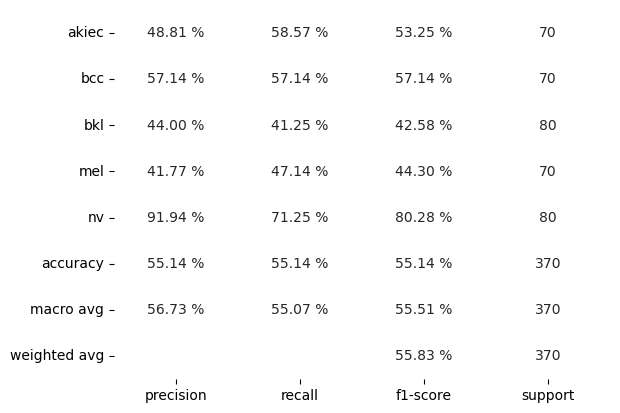

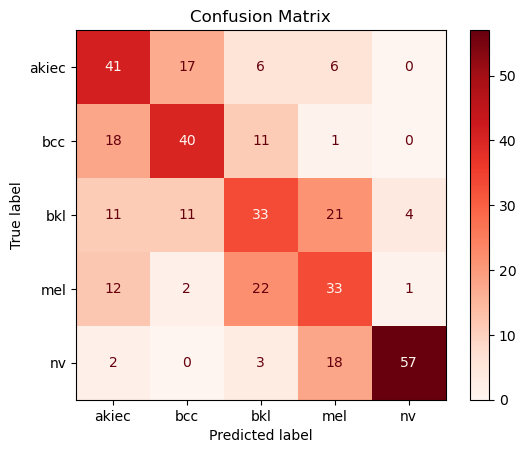

In [41]:
# VALIDATION RESULTS

with torch.no_grad():
    ground_truth = []
    prediction = []
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        ground_truth.append(labels.cpu().tolist())
        prediction.append(predicted.cpu().tolist())
        
# Concatenate lists into single list
ground_truth = [item for sublist in ground_truth for item in sublist]
prediction = [item for sublist in prediction for item in sublist]
        
target_names = ['akiec', 'bcc', 'bkl', 'mel', 'nv']
EvaluateModel(prediction, ground_truth, target_names, 'VALIDATION', now=None, save = False)

In [19]:
# TEST RESULTS

with torch.no_grad():
    ground_truth = []
    prediction = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        ground_truth.append(labels.cpu().tolist())
        prediction.append(predicted.cpu().tolist())
        
# Concatenate lists into single list
ground_truth = [item for sublist in ground_truth for item in sublist]
prediction = [item for sublist in prediction for item in sublist]
        
target_names = ['akiec', 'bcc', 'bkl', 'mel', 'nv']
EvaluateModel(prediction, ground_truth, target_names, 'TEST', now=None, save = False)